# Anomaly detection in python

In this project I explore the problem of anomaly detection. Generally this refers to the task of identifying rare items, events or observations which stick out compared to the remainder of the data. Anomaly detection might be applied in areas such as fraud detection or system health detection. It might also be applied as a pre-processing step to remove bogus data points and avoid the contamination of statitical analyses.

This project is split in two parts; a part on time series data and a part on cross-sectional data.

## Table of contents
- 1. [Imports](#imports)
- 2. [Time series data](#ts)
    - 2.1 [Traffic dataset](#ts_1)
    - 2.2 [Deviation from (moving) average](#ts_2)
    - 2.3 [Deviation from ARIMA model](#ts_3)
- 3. [Cross-sectional data](#cs)
    - 3.1 [Housing dataset](#cs_1)
    - 3.2 [EDA](#cs_2)
    - 3.3 [Problem definition](#cs_3)
    - 3.4 [Empirical and robust covariance](#cs_4)
    - 3.5 [One-Class SVM](#cs_5)
    - 3.6 [Isolation forest](#cs_6)
    - 3.7 [Combining algorithms](#cs_7)
- 4. [Resources & references](#ref)

## 1. Imports <a class="anchor" id="imports"></a>

In [1]:
import pandas as pd
# pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

## 2. Time series data <a class="anchor" id="ts"></a>
### 2.1 Traffic data <a class="anchor" id="ts_1"></a>
For our time series data we make use of data that was distributed specifically with the purpose of testing anomaly detection models. The data is retrieved from the [Numenta Anomaly Benchmark (NAB) repo](https://github.com/numenta/NAB). The data is an excerpt of a larger dataset containing information on traffic in the Twin Cities Metro area in Minnesota, collected by the [Minnesota Department of Transportation](https://www.dot.state.mn.us/index.html). The full dataset includes occupancy, speed, and travel time recoreded at specific sensors. Our dataset comes with just one value, the content of which being irrelevant as we simply focus on detecting outliers.

In [2]:
# Importing data
raw_data = pd.read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/realTraffic/TravelTime_387.csv")
raw_data.head(5)

,timestamp,value
0,2015-07-10 14:24:00,564
1,2015-07-10 14:38:00,730
2,2015-07-10 14:48:00,770
3,2015-07-10 15:03:00,910
4,2015-07-10 15:22:00,1035


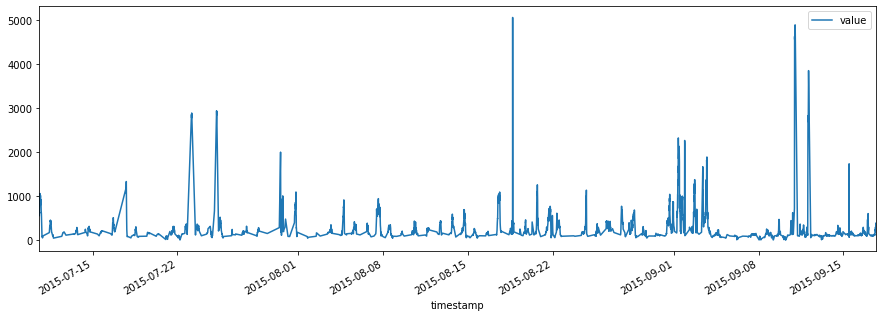

In [3]:
# Converting index
data = raw_data.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.set_index('timestamp')
data.plot(figsize=(15,5))

### 2.2 Deviation from (moving) average <a class="anchor" id="ts_2"></a>
For a stationary(-ish) series like this a straightforward method is to detect ourliers by calculating a point's deviation from either the median or mean. With less stationary data, one can employ a rolling time window as an alternative to a global mean/median.

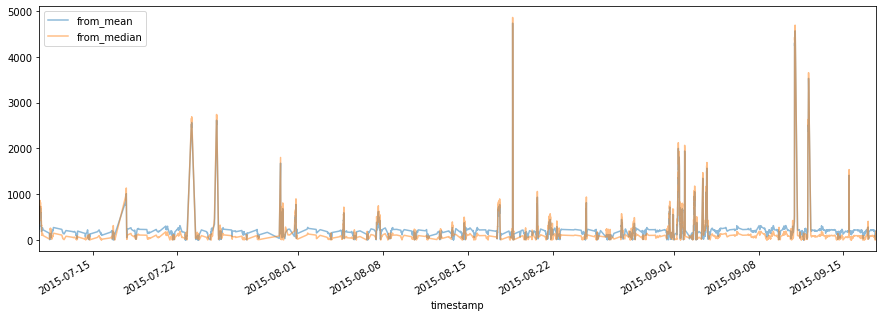

In [4]:
# Deviation from mean
deviation = data.copy()
deviation['from_mean'] = np.abs(deviation['value'] - deviation['value'].mean())
# deviation['from_mean'] = np.abs(deviation['value'] - deviation['value'].rolling(window = 12).mean())
deviation['from_median'] = np.abs(deviation['value'] - deviation['value'].median())

# Plot
deviation[['from_mean', 'from_median']].plot(figsize=(15,5), alpha=.5)

We can then use relate each deviation to the overal std.dev. of the deviations, to measure how 'extreme' the data point is.

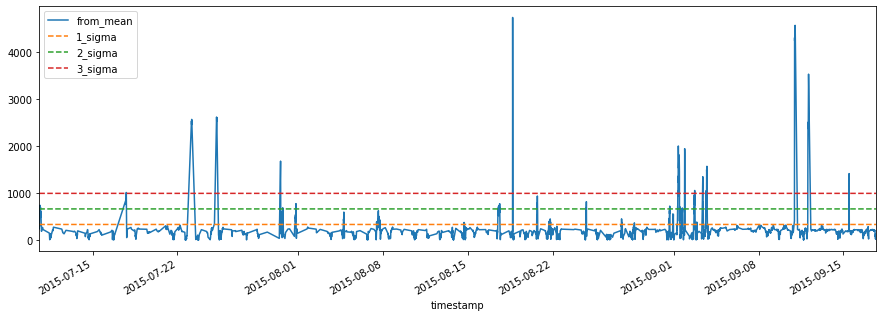

In [5]:
# Plotting deviation and std.dev. of deviations
deviation['1_sigma'] = deviation['from_mean'].std()
deviation['2_sigma'] = deviation['1_sigma'] * 2
deviation['3_sigma'] = deviation['1_sigma'] * 3
deviation[['from_mean', '1_sigma', '2_sigma', '3_sigma']].plot(style=['-']+3*['--'], figsize=(15,5))

Finally we can return points that we deem to be outliers.

In [6]:
# Outliers according to a 3*std.dev. rule, ordered by deviation size.
mask = deviation['from_mean'] > deviation['3_sigma']
mask_sorted = np.argsort(-deviation['from_mean'].loc[mask])
deviation['value'].loc[mask].iloc[mask_sorted][:5]

timestamp
2015-08-18 16:26:00    5059
2015-09-11 00:13:00    4891
2015-09-11 00:25:00    4813
2015-09-10 23:13:00    4630
2015-09-10 23:18:00    4562
Name: value, dtype: int64

### 2.3 Deviation from AR model <a class="anchor" id="ts_3"></a>
The above method should generally only work well when we work with stationary data. A more versatile approach would be to attempt to model our data and highlight points that deviate strongly from our model fit. We'll try fitting an ARIMA model. Note that it might be inappropriate to fit a time series model for this dataset, as the time interval between observations is not constant. Nonetheless, we'll see what an ARIMA model can do.

In [7]:
# Augmented Dicky-Fueller test
def adf_test(data):
    result = adfuller(data)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

adf_test(data)

ADF Statistic: -11.721641967292424
p-value: 1.4087772557375615e-21
Critical Values:
	1%: -3.4329757705711432
	5%: -2.862700050059295
	10%: -2.567387539813443


The series seems to be stationary, meaning we will not apply any differencing. Next we look at which AR or MA components we should introduce.

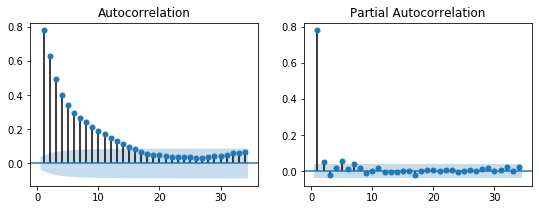

In [8]:
# ACF AND PACF
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,3))
plot_acf(data, zero=False, ax=axes[0])
plot_pacf(data, zero=False, ax=axes[1])
plt.show()

This plots quite clearly seems to indicate an AR(1) structure.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                            AutoReg Model Results                             
Dep. Variable:                  value   No. Observations:                 2500
Model:                     AutoReg(1)   Log Likelihood              -17342.332
Method:               Conditional MLE   S.D. of innovations            249.827
Date:                Wed, 10 Mar 2021   AIC                             11.044
Time:                        20:38:33   BIC                             11.051
Sample:                             1   HQIC                            11.046
                                 2500                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     71.3140      6.443     11.069      0.000      58.686      83.942
value.L1       0.7803      0.013     62.387      0.000       0.756       0.805
                                    Roots           

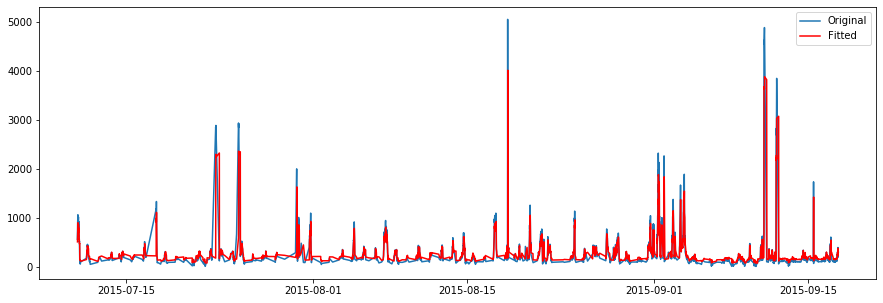

In [9]:
# Fit the AR model
ar_fit = AutoReg(data, 1).fit()

# Print model summary
print(ar_fit.summary())

# Plot 
plt.figure(figsize=(15,5))
plt.plot(data)
plt.plot(ar_fit.predict(), color='red')
plt.legend(['Original', 'Fitted'])
plt.show()

We now calculate the residuals. Once again we can compare residuals with the std. dev. of the full residual set.

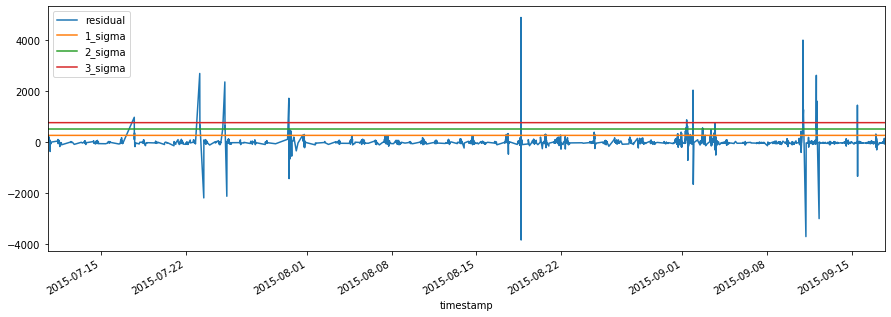

In [10]:
# Calculate residuals
residuals = pd.DataFrame((data['value'] - ar_fit.predict()).dropna())
residuals.columns = ['residual']
residuals['1_sigma'] = residuals['residual'].std()
residuals['2_sigma'] = residuals['1_sigma'] * 2
residuals['3_sigma'] = residuals['1_sigma'] * 3

# Plot residuals and (one sided) std.dev.
residuals.plot(figsize=(15,5))

A problem is that the AR(1) structure will cause the model to predict that each outlier will be follow by another high value. If this is not the case, one outlier will therefore cause two large residuals in a row; one positive and one negative. The same holds when there is a series of extremely high values, after which the series returns suddenly. In this case we'd get a pattern such as large pos residual -> small residual -> large neg residual. We can avoid these problems by simply requiring that our residual is positive. Using this method we'll specifically single out the **first** observation that's out of the orginary, or that starts a spike in the observed value.

In [11]:
# Make mask
residuals['outlier'] = residuals['residual'] > residuals['3_sigma']
residuals['value'] = data['value']

# Print values and order them by outlier size
temp = residuals[['value', 'residual']].loc[residuals['outlier']]
temp.sort_values('residual', ascending=False).head(5)

,value,residual
timestamp,,
2015-08-18 16:26:00,5059,4877.660568
2015-09-10 23:13:00,4630,3988.270566
2015-07-23 03:55:00,2858,2679.781856
2015-09-12 01:42:00,2769,2607.168619
2015-07-25 05:39:00,2941,2346.870210


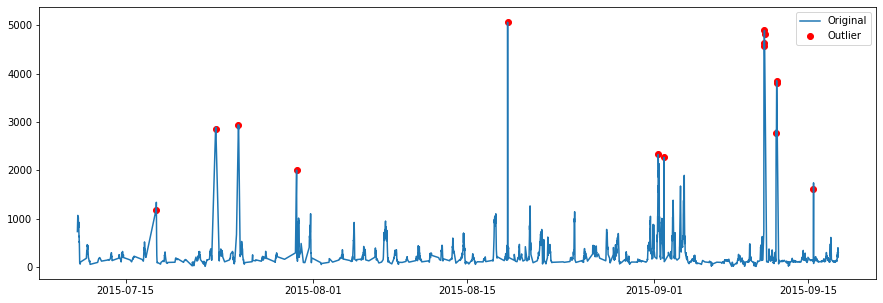

In [12]:
# Another plot, for fun
residuals['value_points'] = residuals.loc[residuals['outlier'], ['value']]
plt.figure(figsize=(15,5))
plt.plot(residuals.index, residuals['value'])
plt.scatter(residuals.index, residuals['value_points'], color='red')
plt.legend(['Original', 'Outlier'])
plt.show()

## 3. Cross-sectional data <a class="anchor" id="cs"></a>
### 3.1 Housing dataset <a class="anchor" id="cs_1"></a>
Once we lose the time-dependency of our variables, some other options open up (even though some of the methods we discuss next could work very well in a time series context as well). We'll use the [boston housing dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv) to compare a number of anomaly detection algorithms. The full dataset consists of the following columns, where each row represents a district.
1. **CRIM**      per capita crime rate by town
2. **ZN**        proportion of residential land zoned for lots over 25,000 sq.ft.
3. **INDUS**     proportion of non-retail business acres per town
4. **CHAS**      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. **NOX**       nitric oxides concentration (parts per 10 million)
6. **RM**        average number of rooms per dwelling
7. **AGE**       proportion of owner-occupied units built prior to 1940
8. **DIS**       weighted distances to five Boston employment centres
9. **RAD**       index of accessibility to radial highways
10. **TAX**      full-value property-tax rate per 10,000
11. **PTRATIO**  pupil-teacher ratio by town
12. **B**        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. **LSTAT**    \% lower status of the population
14. **MEDV**     Median value of owner-occupied homes in 1000's


In [13]:
# Import taw data
raw_housing = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv', header=None)
raw_housing.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [14]:
# Data size
raw_housing.shape

(506, 14)

In [15]:
# Renaming columns
housing = raw_housing.copy()
housing.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
                   'PTRATIO', 'B', 'LSTAT', 'MEDV']

### 3.2 EDA <a class="anchor" id="cs_2"></a>
We start with some preliminary analysis on the full dataset.

In [16]:
# General describe
housing.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


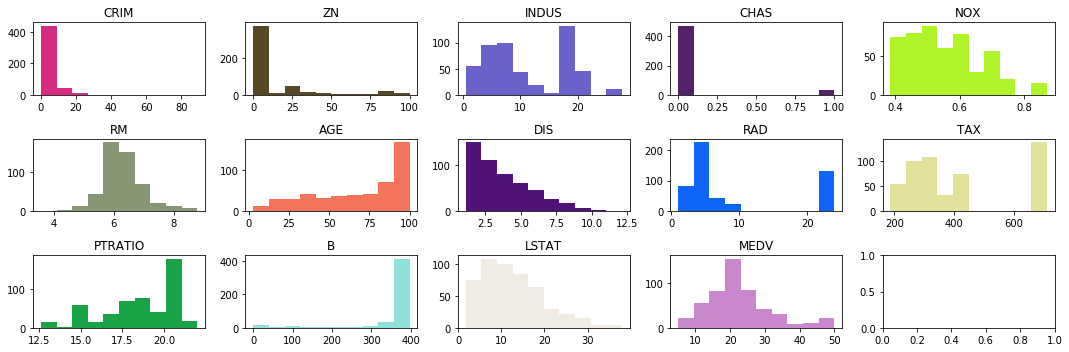

In [17]:
# Histograms
n_cols = len(housing.columns)
fix, axes = plt.subplots(nrows = round(n_cols/5), ncols=5, figsize=(15,5))
axes = axes.ravel()
for i, column in enumerate(housing.columns):
    axes[i].hist(housing[column], color=np.random.rand(3))
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

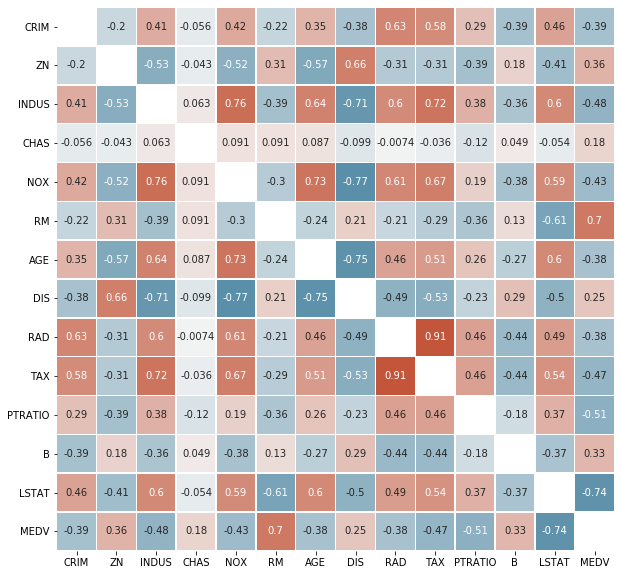

In [18]:
# Correlation plot
# ignore_corr = ['var1', 'var2']
# keep_corr = [c for c in df.columns if c not in ignore_corr]
corr_matrix = housing.corr()
plt.figure(figsize = (10, 10))
size = len(housing.columns)
mask = np.diag([1]*size)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot = True, cbar = False, cmap=cmap, 
            linewidths=.5, center=0, mask=mask)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top 
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values plt.show()
plt.show()

### 3.3 Problem definition <a class="anchor" id="cs_3"></a>
Imagine we're looking for houses and we want to make sure we find a kid-friendly neighbourhood. In this case it might be worthwile to highlight some neighbourhoods that stand out, either for good or bad reasons. For instance we might take the PTRATIO (teachers per kid) and NOX (unhealthy air) variables, and see if we can find any outliers with regard to these variables.

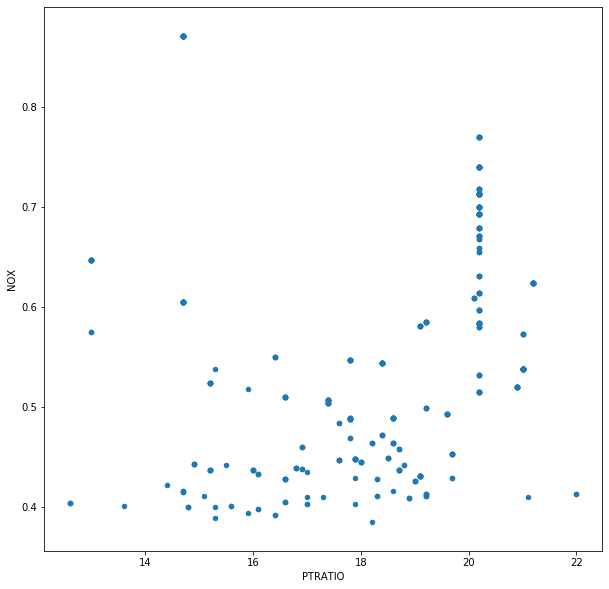

In [19]:
# Plot
housing.plot.scatter(x='PTRATIO', y='NOX', figsize=(10,10))

### 3.4 Empirical and robust covariance <a class="anchor" id="cs_4"></a>
We'll start by identifying outliers based on the covariance ellipsoid. The problem is that outliers will de-form this ellipsoid, such that they become less likely to be spotted. 

A robust alternative to the emperical covariance ellipsoid can be attained through applying the Minimum Covariance Determinant method. Here we seek to find a subset of the data for which the determinant of the covariance matrix is the smallest, thereby often excluding outliers. The plot that shows the ellipsoids is based on code in [this example](https://scikit-learn.org/stable/auto_examples/applications/plot_outlier_detection_wine.html#sphx-glr-auto-examples-applications-plot-outlier-detection-wine-py).

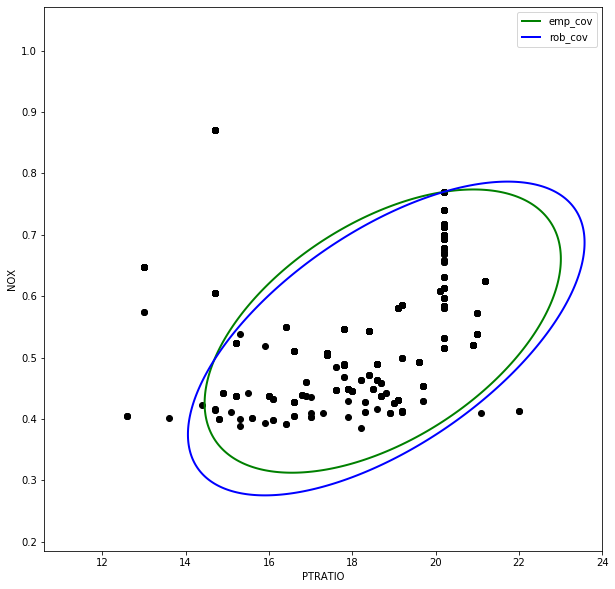

In [20]:
# Specify classifiers, contamination equals the expected % of outliers
classifiers = {'emp_cov': EllipticEnvelope(support_fraction=1., contamination=.1),
               'rob_cov': EllipticEnvelope(contamination=.1)}

# Function for visual comparison
def compare(classifiers):

    # Plot the frontier
    colors = ['g', 'b', 'r', 'c', 'm', 'y']
    legend1 = {}
    xx1, yy1 = np.meshgrid(np.linspace(housing['PTRATIO'].min()-2, housing['PTRATIO'].max()+2, 500), 
                           np.linspace(housing['NOX'].min()-.2, housing['NOX'].max()+.2, 500))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        plt.figure(1, figsize=(10,10))
        clf.fit(housing[['PTRATIO', 'NOX']])
        Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
        Z1 = Z1.reshape(xx1.shape)
        legend1[clf_name] = plt.contour(
            xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i])

    legend1_values_list = list(legend1.values())
    legend1_keys_list = list(legend1.keys()) 

    plt.scatter(housing['PTRATIO'], housing['NOX'], color='black')
    plt.legend([item.collections[0] for item in legend1_values_list],
               [item for item in legend1_keys_list])
    plt.xlabel("PTRATIO")
    plt.ylabel("NOX")
    
compare(classifiers)

We can see that the outliers have a notable effect on the shape of the ellipsoid. In this case however, the two methods seem to 'agree' for the most part on whether an observation is an outlier or not. 

Before we make predictions, let's consider some additional methods. 

### 3.5 One-Class SVM <a class="anchor" id="cs_5"></a>
One class SVM seeks to find a hyperplane that seperates a given dataset from the origin. This way the algorithm computes a binary function (spcified in a 'higher dimension' such that the hyperplane can take on more complex shapes) which returns nonzero values for regions that capture most of the data points. Details can be read in the [original paper](https://scholar.google.nl/citations?view_op=view_citation&hl=en&user=DZ-fHPgAAAAJ&cstart=400&pagesize=100&sortby=pubdate&citation_for_view=DZ-fHPgAAAAJ:GFxP56DSvIMC) on the subject.

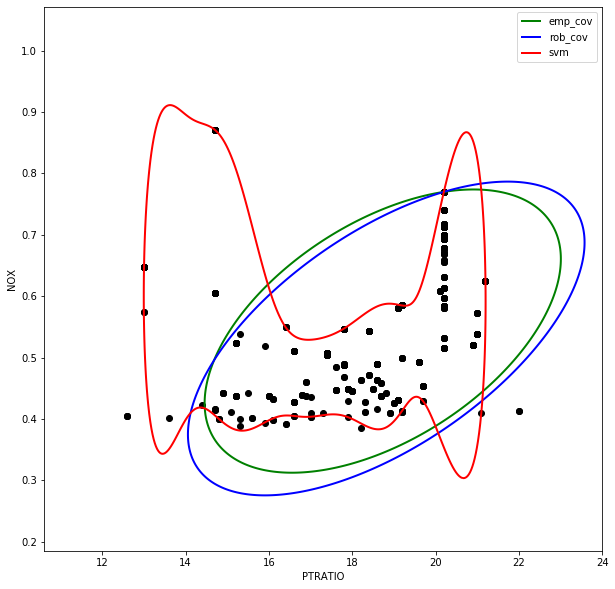

In [21]:
# Adding one class svm
classifiers = {'emp_cov': EllipticEnvelope(support_fraction=1., contamination=.1),
               'rob_cov': EllipticEnvelope(contamination=.1), 
               'svm': OneClassSVM(nu=.1, kernel='rbf', gamma='auto')}

compare(classifiers)

By applying the Radial Base Function (`kernel='rbf'`) we manage to produce a more complex decision border. Next we consider one more technique.

### 3.6 Isolation forest <a class="anchor" id="cs_6"></a>
The [isolation forest](https://en.wikipedia.org/wiki/Isolation_forest) algorithm relies on the fact that anomalous instances should be easier to seperate than the rest of the dataset. The algorithm will recursively parition the feature space according to one of the attributes, where the parition takes place at a random place between the maximum and minimum value for the specific attribute. This process is continued untill all points are isolated. Points that are isolated within a smaller number of splits are more likely to be anomalous.

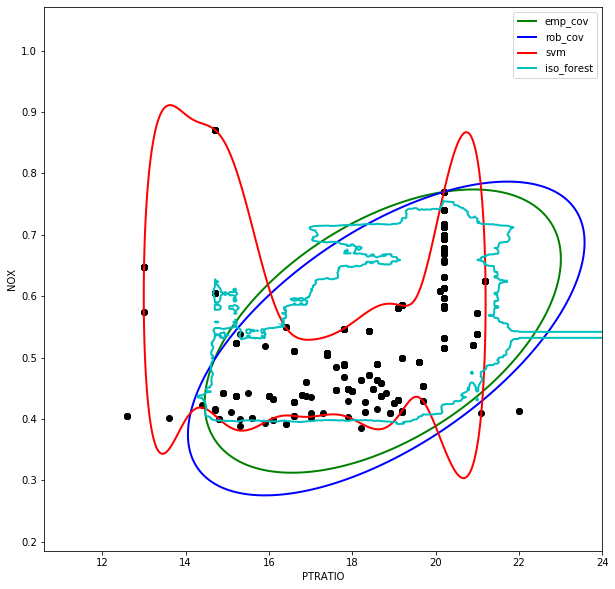

In [22]:
# Adding isolation forest
classifiers = {'emp_cov': EllipticEnvelope(support_fraction=1., contamination=.1),
               'rob_cov': EllipticEnvelope(contamination=.1), 
               'svm': OneClassSVM(nu=.1, kernel='rbf', gamma='auto'), 
               'iso_forest': IsolationForest(contamination=.1, random_state=42)}

compare(classifiers)

### 3.7 Combining algorithms <a class="anchor" id="cs_7"></a>
We can combine the verdicts from all our algorithms into one score. E.g. if all algorithms vote that an observation is an outlier, the observation gets a score 4 etc..

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

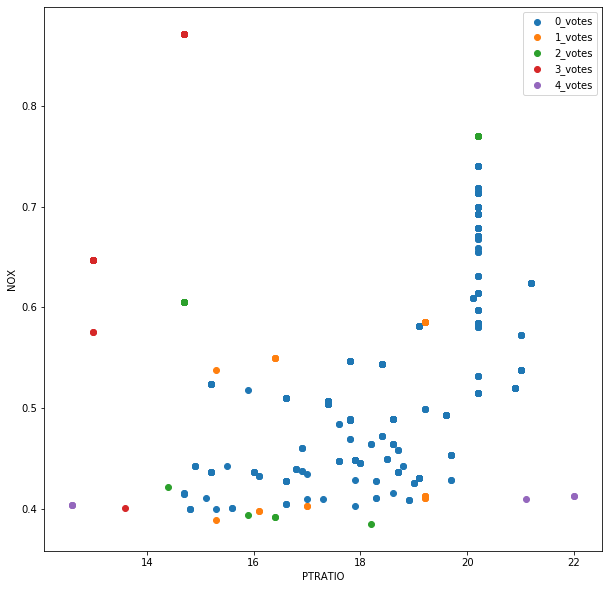

In [23]:
# Combine predictions
def pred_combined(classifiers, plot=True):
    predictions = housing[['PTRATIO', 'NOX']]
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        predictions[clf_name + '_p'] = clf.fit_predict(housing[['PTRATIO', 'NOX']])
        predictions[clf_name + '_p'] = predictions[clf_name + '_p'].map(lambda x: 1 if x == -1 else 0)

    predictions['combined'] = predictions.iloc[:, 2:].sum(axis=1)
    to_plot = housing[['PTRATIO', 'NOX']]
    group = predictions['combined'].astype(str) + '_votes'
    f, ax = plt.subplots(1, figsize=(10,10))
    for i in np.unique(group):
        mask = group == i
        plt.scatter(to_plot[mask].iloc[:,0], to_plot.loc[mask].iloc[:,1], label=i)

    ax.legend()
    ax.set_xlabel("PTRATIO")
    ax.set_ylabel("NOX")
    return(predictions)

outcome = pred_combined(classifiers)

At last we can take a look at the observations that received a score of 4 or 3.

In [24]:
# Show the top outliers
mask = (outcome['combined'] == 3) | (outcome['combined'] == 4)
outcome.loc[mask, ['PTRATIO', 'NOX', 'combined']].sort_values('combined', ascending=False).head(10)

,PTRATIO,NOX,combined
54,21.1,0.410,4
197,12.6,0.404,4
354,22.0,0.413,4
198,12.6,0.404,4
196,12.6,0.404,4
355,22.0,0.413,4
147,14.7,0.871,3
143,14.7,0.871,3
283,13.6,0.401,3
268,13.0,0.575,3


For example the 2nd district in the table above is a district with a favourable student:teacher ratio and low NOX values. This might be a good area to consider.

## 4. Resources and references <a class="anchor" id="ref"></a>
- Outlier detection in scikit-learn:  
https://scikit-learn.org/stable/modules/outlier_detection.html
- Outlier detection prices (Clustering, Isolation forest, SVM, Gaussian):   
https://towardsdatascience.com/time-series-of-price-anomaly-detection-13586cd5ff46
- Outlier detection industrial proces (PCA, Autoencoder):   
https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770
- Simple outlier detection time series (Moving average):  
https://stats.stackexchange.com/questions/427327/simple-outlier-detection-for-time-series
- Anomaly data sets:  
https://github.com/numenta/NAB/tree/master/data
- Smoothing seasonality and trends:  
https://www.oreilly.com/library/view/anomaly-detection-for/9781492042341/ch04.html
- Anomaly detection using ARIMA:  
https://towardsdatascience.com/anomaly-detection-with-time-series-forecasting-c34c6d04b24a
- Empirical vs Robust Covariance:  
https://scikit-learn.org/stable/auto_examples/applications/plot_outlier_detection_wine.html#sphx-glr-auto-examples-applications-plot-outlier-detection-wine-py
- [Schölkopf, B., Williamson, R. C., Smola, A. J., Shawe-Taylor, J., & Platt, J. C. (1999, December). Support vector method for novelty detection. In NIPS (Vol. 12, pp. 582-588).](https://scholar.google.nl/citations?view_op=view_citation&hl=en&user=DZ-fHPgAAAAJ&cstart=400&pagesize=100&sortby=pubdate&citation_for_view=DZ-fHPgAAAAJ:GFxP56DSvIMC)
- On kernels:  
https://towardsdatascience.com/kernel-function-6f1d2be6091